<a href="https://colab.research.google.com/github/dewizunuvi/Deteksi-Autisme/blob/main/VGG-16_3d_to_2d_RGB_Dp%2BCV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Klasifikasi MRI Autisme ResNet-50**
Gambar Nifti diubah ke 2D, RGB, Cross validation, Dropout


#### Import nibabel package to read NIfTI images

In [19]:
import keras
import numpy as np
import nibabel as nib
import tensorflow as tf
from keras import applications

#### Import all the keras required library

In [20]:
import os
from keras import layers
from google.colab import drive
import matplotlib.pyplot as plt
from keras.models import Sequential, Model
from keras.losses import categorical_crossentropy
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D

from sklearn.model_selection import KFold
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split

#### Fatch all the preprocessed images from the folder, preprocessing is done in SPM (matlab)

In [21]:
# Mount Google Drive
drive.mount('/content/drive')

# Set path to folder containing NIfTI files
folder_path_autism = "/content/drive/MyDrive/Dataset_Autis/Autism"
folder_path_control = "/content/drive/MyDrive/Dataset_Autis/Control"

# daftar file .nii.gz dari folder1
files1 = [os.path.join(folder_path_autism, f) for f in os.listdir(folder_path_autism) if f.endswith('.nii.gz')]

# daftar file .nii.gz dari folder2
files2 = [os.path.join(folder_path_control, f) for f in os.listdir(folder_path_control) if f.endswith('.nii.gz')]

# Load images from the two folders
images1 = [nib.load(f) for f in files1]
images2 = [nib.load(f) for f in files2]

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [22]:
# Combine the two sets of images
dataf = images1 + images2

# Generate labels for the images
labels = [1] * len(images1) + [0] * len(images2)

#### Data Conversion from 3D to 2D and introduce 3 channels (RGB) because the predefined model always takes 2D images with 3 channels in Keras.

In [23]:
# create an empty list to store the slice data
slice_list = []

# loop over the images and convert to 2D
for img in images1 + images2:
    # get the image data as a numpy array
    data = img.get_fdata()
    # select a slice to display (e.g. the middle slice along the first axis)
    slice_idx = data.shape[0] // 2
    # extract the 2D slice data
    slice_data = data[slice_idx, :, :]
    # add the slice data to the list
    slice_list.append(slice_data)

In [24]:
len(slice_list)

1102

In [25]:
data_array = np.array(slice_list)

In [26]:
data_array.shape

(1102, 73, 61)

#Turn to RGB

In [27]:
data_image=np.stack([data_array]*3, axis=-1)

In [28]:
data_image.shape

(1102, 73, 61, 3)

#### Split the data into train and test in the 70:30 ratio.

In [29]:
x_train, x_test, y_train, y_test = train_test_split(data_image, labels, test_size=0.2)
y_train=np.array(y_train)


input_shape = (73, 61,3)
x_train = x_train.astype('float32')
y_train = keras.utils.to_categorical(y_train)
y_old_test=y_test
y_test = keras.utils.to_categorical(y_test)


#### Use the ResNet50 model.

In [30]:
from keras.layers import Dropout, Flatten, Dense
from keras.applications import VGG16

# Load the ResNet50 model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers on top of the base model
x = base_model.output
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)  # Add a dropout layer with dropout rate of 0.5
predictions = Dense(2, activation='softmax')(x)

# Create the model
model = Model(inputs=base_model.input, outputs=predictions)

In [31]:
print(model.summary())

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 73, 61, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 73, 61, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 73, 61, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 36, 30, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 36, 30, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 36, 30, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 18, 15, 128)       0   

#### Compile and train the model with Adam optimizer

In [32]:
# define early stopping callback
early_stop = EarlyStopping(monitor='val_loss', patience=5)

In [33]:
# Split data into K=5 folds
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

In [16]:
# Compile the model
model.compile(optimizer=keras.optimizers.Adam(lr=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model with K-fold cross validation
for fold, (train_idx, val_idx) in enumerate(kfold.split(x_train, y_train)):
    print(f'Fold {fold+1} Training ------------')
    x_train_fold = x_train[train_idx]
    y_train_fold = y_train[train_idx]
    x_val_fold = x_train[val_idx]
    y_val_fold = y_train[val_idx]

    history = model.fit(x_train_fold, y_train_fold, batch_size=100, epochs=40, validation_data=(x_val_fold, y_val_fold), callbacks=[early_stop])

    print(f"Fold {fold+1} Validation Accuracy: {np.mean(history.history['val_accuracy']):.4f}")

Fold 1 Training ------------


/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/40
8/8 [==============================] - 47s 6s/step - loss: 0.8581 - accuracy: 0.4886 - val_loss: 0.7499 - val_accuracy: 0.4576
Epoch 2/40
8/8 [==============================] - 46s 6s/step - loss: 0.8134 - accuracy: 0.5213 - val_loss: 0.7306 - val_accuracy: 0.4520
Epoch 3/40
8/8 [==============================] - 46s 6s/step - loss: 0.7696 - accuracy: 0.5327 - val_loss: 0.7185 - val_accuracy: 0.4576
Epoch 4/40
8/8 [==============================] - 46s 6s/step - loss: 0.8000 - accuracy: 0.4972 - val_loss: 0.7123 - val_accuracy: 0.4633
Epoch 5/40
8/8 [==============================] - 46s 6s/step - loss: 0.8170 - accuracy: 0.4929 - val_loss: 0.7083 - val_accuracy: 0.4802
Epoch 6/40
8/8 [==============================] - 46s 6s/step - loss: 0.8159 - accuracy: 0.5099 - val_loss: 0.7082 - val_accuracy: 0.4746
Epoch 7/40
8/8 [==============================] - 46s 6s/step - loss: 0.8104 - accuracy: 0.4886 - val_loss: 0.7061 - val_accuracy: 0.4689
Epoch 8/40
8/8 [==================

#### The model loss and accuracy on test data.

In [17]:
#x_test = X_test.reshape(X_test.shape[0],145,121,3)
x_test = x_test.astype('float32')
    # Normalizing the RGB codes by dividing it to the max RGB value.
print('Number of images in x_test', x_test.shape[0])
model.evaluate(x_test,y_test)


Number of images in x_test 221
7/7 [==============================] - 10s 1s/step - loss: 0.6890 - accuracy: 0.5656


[0.6890151500701904, 0.5656108856201172]

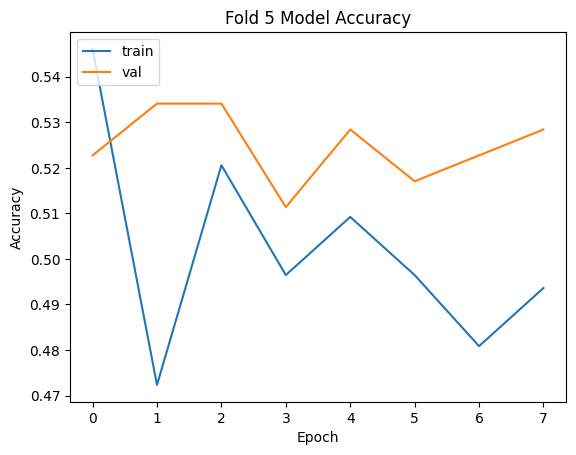

In [18]:
# Plot the training and validation accuracy for each epoch
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title(f'Fold {fold+1} Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()